# Dependencies

In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Load data

In [2]:
new_data = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_data = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

old_data = old_data[['image', 'level']]
old_data.columns = new_data.columns
new_data['data'] = 'new'
old_data['data'] = 'old'
old_data["id_code"] = old_data["id_code"].apply(lambda x: x + ".jpeg")
new_data["id_code"] = new_data["id_code"].apply(lambda x: x + ".png")
test_df["id_code"] = test_df["id_code"].apply(lambda x: x + ".png")

# Sample rows of diagnosis = 0
diag_0 = old_data[old_data['diagnosis'] == 0].sample(frac=0.25, random_state=seed)
diag_oth = old_data[old_data['diagnosis'] != 0]
old_data = diag_0.append(diag_oth)

train_df = new_data.append(old_data)
print('Number of train samples: ', train_df.shape[0])
print('Number of test samples: ', test_df.shape[0])
display(train_df.head())

Number of train samples:  19430
Number of test samples:  1928


,id_code,diagnosis,data
0,000c1434d8d7.png,2,new
1,001639a390f0.png,4,new
2,0024cdab0c1e.png,1,new
3,002c21358ce6.png,0,new
4,005b95c28852.png,0,new


# Hold-out train validation split (50%) of new dataset data

In [3]:
train, validation = train_test_split(new_data, test_size=0.5, random_state=seed)
train = train.append(old_data)

# Train & Validation label distribution

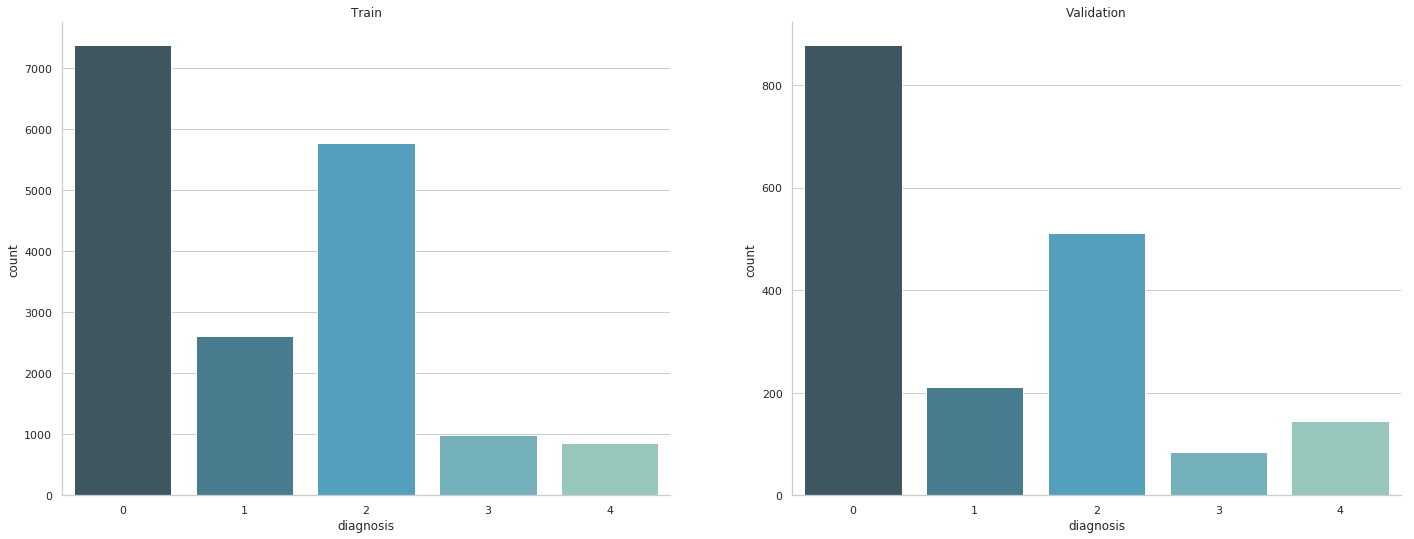

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=train, palette="GnBu_d", ax=ax1).set_title('Train')
sns.countplot(x="diagnosis", data=validation, palette="GnBu_d", ax=ax2).set_title('Validation')
sns.despine()
plt.show()

# Output hold-out set

In [5]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)
train_complete.to_csv('hold-out_5.csv', index=False)
print('Number of train samples: ', train.shape[0])
print('Number of validation samples: ', validation.shape[0])
display(train_complete.head())

Number of train samples:  17599
Number of validation samples:  1831


,id_code,diagnosis,data,set
2213,9b70f84400af.png,0,new,train
2792,c0e509786f7f.png,4,new,train
2522,aeab0a63bcaf.png,0,new,train
3364,e97ecf4355cb.png,0,new,train
3484,f26b02ead915.png,0,new,train


# Hold-out train validation split (30%) of new dataset data

In [6]:
train, validation = train_test_split(new_data, test_size=0.3, random_state=seed)
train = train.append(old_data)

# Output hold-out set

In [7]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)
train_complete.to_csv('hold-out_3.csv', index=False)
print('Number of train samples: ', train.shape[0])
print('Number of validation samples: ', validation.shape[0])
display(train_complete.head())

Number of train samples:  18331
Number of validation samples:  1099


,id_code,diagnosis,data,set
1414,6324d77cf926.png,0,new,train
745,3599029efeb3.png,0,new,train
3516,f4e68b61f480.png,0,new,train
1490,6852f4531591.png,0,new,train
1757,7c2e852171c0.png,0,new,train


# 5-Fold split

In [8]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(new_data, new_data['diagnosis'])):
    print('Fold: %s, Train size: %s, Validation size %s' % 
          (fold_n, len(trn_idx), len(val_idx)))
    new_data[('fold_%s' % fold_n)] = 0
    new_data[('fold_%s' % fold_n)].loc[trn_idx] = 'train'
    new_data[('fold_%s' % fold_n)].loc[val_idx] = 'validation'
    old_data[('fold_%s' % fold_n)] = 0
    old_data[('fold_%s' % fold_n)] = 'train'
    
train_df = old_data.append(new_data)
display(train_df.head())

Fold: 0, Train size: 2929, Validation size 733
Fold: 1, Train size: 2929, Validation size 733
Fold: 2, Train size: 2929, Validation size 733
Fold: 3, Train size: 2930, Validation size 732
Fold: 4, Train size: 2931, Validation size 731


,id_code,diagnosis,data,fold_0,fold_1,fold_2,fold_3,fold_4
32132,40576_left.jpeg,0,old,train,train,train,train,train
26166,33112_left.jpeg,0,old,train,train,train,train,train
25243,31961_right.jpeg,0,old,train,train,train,train,train
2010,2515_left.jpeg,0,old,train,train,train,train,train
31965,40364_right.jpeg,0,old,train,train,train,train,train


# Train & Validation label distribution

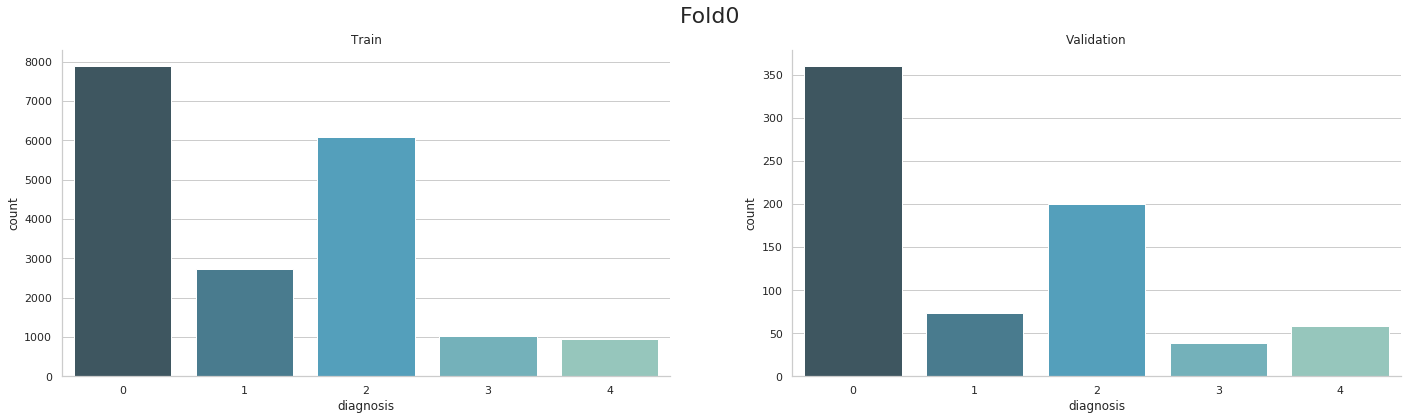

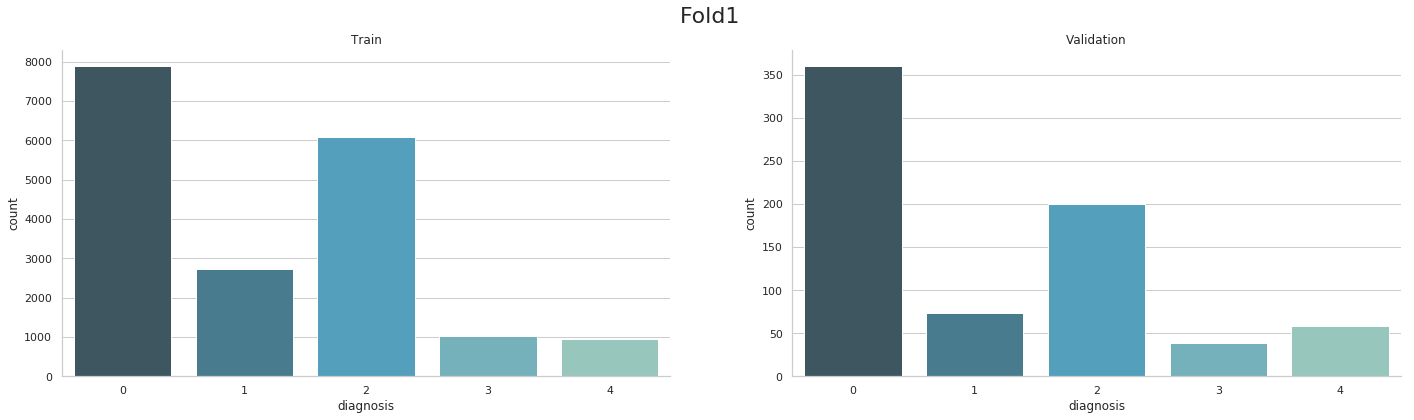

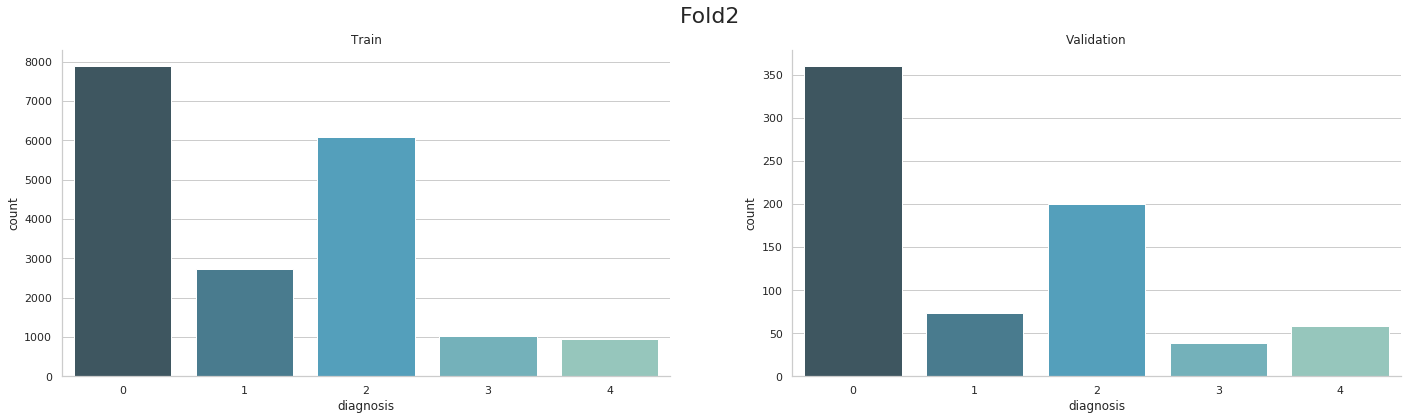

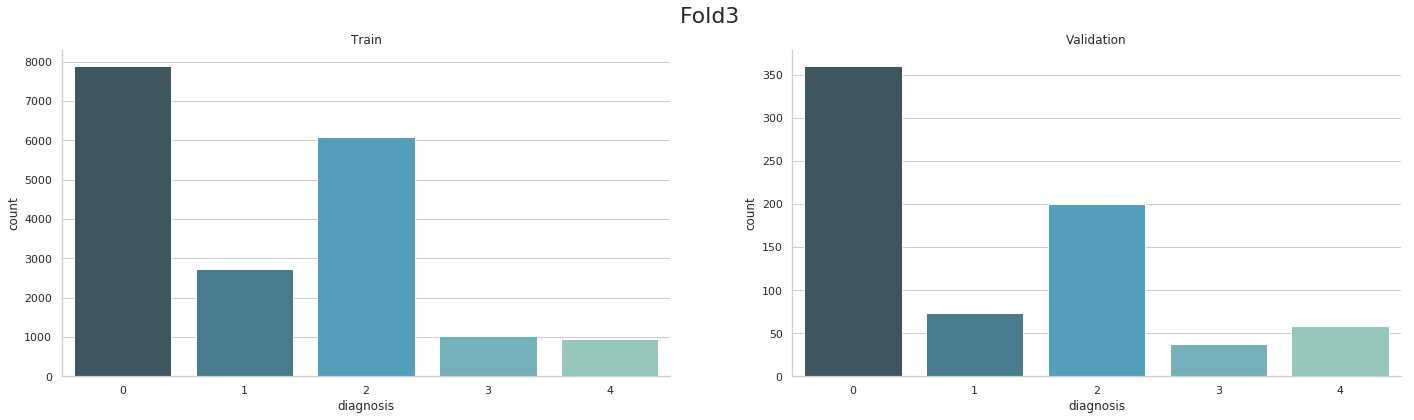

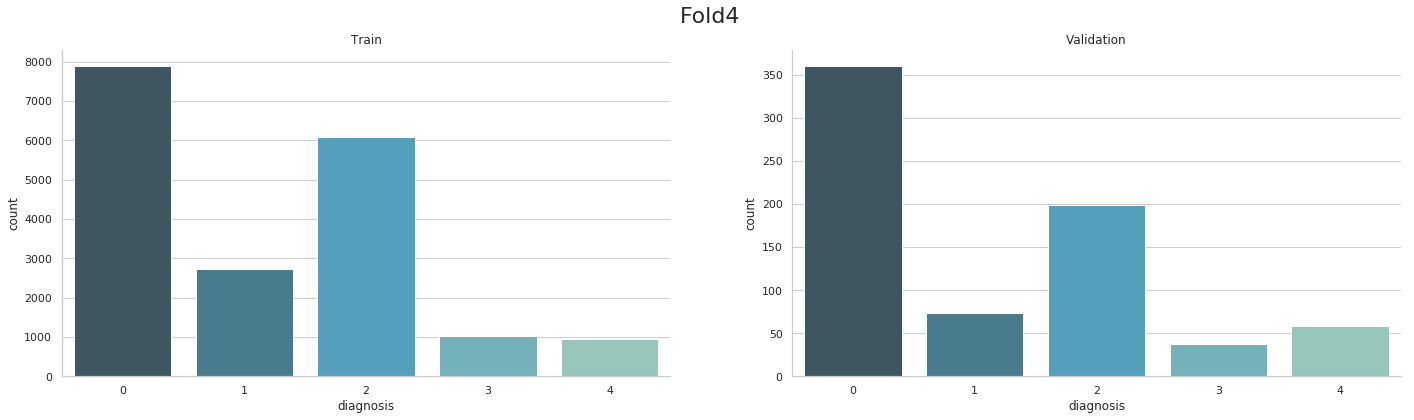

In [9]:
for fold_n, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df['diagnosis'])):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold%s'%fold_n, fontsize=22)    
    sns.countplot(x="diagnosis", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="diagnosis", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Output 5-fold set

In [10]:
train_df.to_csv('5-fold.csv', index=False)
print('Number of train samples: ', train_df[train_df[('fold_%s' % fold_n)] == 'train'].shape[0])
print('Number of validation samples: ', train_df[train_df[('fold_%s' % fold_n)] == 'validation'].shape[0])
display(train_df.head())

Number of train samples:  18699
Number of validation samples:  731


,id_code,diagnosis,data,fold_0,fold_1,fold_2,fold_3,fold_4
32132,40576_left.jpeg,0,old,train,train,train,train,train
26166,33112_left.jpeg,0,old,train,train,train,train,train
25243,31961_right.jpeg,0,old,train,train,train,train,train
2010,2515_left.jpeg,0,old,train,train,train,train,train
31965,40364_right.jpeg,0,old,train,train,train,train,train
